**Training a classifier**
In this section, we'll:

- Load a pre-generated image dataset (CIFAR10)
- Define a convolutional neural network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

In [51]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The **CIFAR10 dataset** contains images of size **32x32**, each of which is one of 10 possible classes.

First we'll load up the datasets. PyTorch has built-in code to download and load this dataset, but you can write your own `DataLoader` to load images from file, etc., for your own dataset.

In [52]:
# we use this transform to automatically turn each image into 
# a tensor and normalize it
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset =  torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader =  torch.utils.data.DataLoader(testset,  batch_size=4,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Each sample in this particular dataset is one **32x32 image**, and one **class label**.

Now let's load a few training images. It's always good to visualize your data.

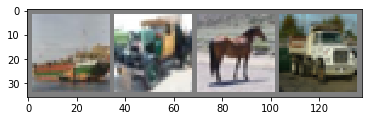

label ids:
tensor([8, 9, 7, 9])
label names:
 ship truck horse truck


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# define a function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# images and labels contain 4 samples because batch_size=4

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('label ids:')
print(labels)
print('label names:')
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

We have our `DataLoader` to load both the images and the labels. Now, let's define a simple neural network we'll use for predicting the class from the input images.

In [54]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# move the network weights to the GPU
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Let's look at this network setup. All neural networks are just classes that inherit `nn.Module`. They contain layers as member fields, defined in `__init__`, and it implements a `forward(x)` function that will take in an input image and will output data representing a class.

For example, the first layer `conv1` is a 2D convolutional layer, that has *3 input channels* (for the RGB input image), *6 output layers*, and a *5x5 kernel size*. The weights for `conv1` are just another `Tensor`:

In [55]:
print("conv1 weights are of size ", net.conv1.weight.size())
print(net.conv1.weight)

conv1 weights are of size  torch.Size([6, 3, 5, 5])
Parameter containing:
tensor([[[[-0.0387, -0.0722,  0.0970, -0.0077,  0.0750],
          [ 0.0822, -0.0106, -0.0907, -0.0086, -0.0690],
          [-0.0813, -0.0288,  0.0939,  0.0841, -0.0890],
          [ 0.0174,  0.0978,  0.0067,  0.0858,  0.0865],
          [ 0.1011,  0.1077, -0.0939,  0.0837,  0.0235]],

         [[-0.0095,  0.1150,  0.0791, -0.0300,  0.1078],
          [-0.0272, -0.0701,  0.0323, -0.0641,  0.0466],
          [-0.0789, -0.0458, -0.0281,  0.0341,  0.0735],
          [ 0.0819,  0.0337, -0.0313,  0.0295,  0.0277],
          [ 0.0071,  0.0189, -0.0503, -0.0104, -0.0334]],

         [[-0.0887, -0.1003,  0.0941, -0.0370,  0.0588],
          [ 0.0112, -0.0669, -0.0054,  0.0019, -0.1043],
          [ 0.1103, -0.0035, -0.0033,  0.0884, -0.0418],
          [-0.0269, -0.0178, -0.0660, -0.0390,  0.0822],
          [-0.0824, -0.0939,  0.0922, -0.0089, -0.0209]]],


        [[[ 0.0685, -0.0717, -0.0791,  0.1147, -0.0914],
      

The final layer `fc3` is a fully-connected linear layer that has 84 input channels and 10 output channels (representing the 10 possible class labels in the dataset).

In [56]:
print("fc3 weights are of size ", net.fc3.weight.size())
print(net.fc3.weight)

fc3 weights are of size  torch.Size([10, 84])
Parameter containing:
tensor([[ 2.6989e-02,  4.4618e-02,  8.0008e-03, -9.6163e-02, -1.2604e-02,
         -7.1213e-02, -3.0844e-02, -6.3722e-02, -2.9657e-02,  9.6938e-02,
          1.0780e-01, -8.6953e-02, -1.0288e-01, -3.3683e-02,  5.3339e-02,
          1.7839e-02,  9.0630e-02, -3.5093e-02,  3.7443e-02, -1.4735e-02,
          6.8957e-02, -2.3047e-02, -6.6802e-02, -7.9486e-04,  8.0825e-02,
         -1.0135e-01, -1.4989e-02,  1.1766e-02, -2.1797e-02, -1.0847e-01,
         -6.6424e-02, -5.0704e-02, -9.4031e-02,  1.2305e-02, -1.0522e-01,
         -7.7845e-02, -8.0706e-02,  7.5405e-02,  9.1713e-02,  4.2054e-02,
          9.2669e-02,  1.6723e-02, -6.3624e-02, -5.4975e-02,  4.9320e-02,
          6.3828e-02,  9.2768e-02, -1.9659e-02,  7.9434e-02,  4.5602e-02,
         -1.0510e-01,  2.8048e-02,  8.3621e-03, -1.0384e-01,  9.0949e-02,
         -1.1024e-02,  8.0969e-02, -1.9528e-03,  7.5699e-02,  3.6454e-02,
          5.6834e-02,  1.1828e-03, -5.8073e-

       requires_grad=True)


Here's all the weights of the network:

In [57]:
net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0387, -0.0722,  0.0970, -0.0077,  0.0750],
                        [ 0.0822, -0.0106, -0.0907, -0.0086, -0.0690],
                        [-0.0813, -0.0288,  0.0939,  0.0841, -0.0890],
                        [ 0.0174,  0.0978,  0.0067,  0.0858,  0.0865],
                        [ 0.1011,  0.1077, -0.0939,  0.0837,  0.0235]],
              
                       [[-0.0095,  0.1150,  0.0791, -0.0300,  0.1078],
                        [-0.0272, -0.0701,  0.0323, -0.0641,  0.0466],
                        [-0.0789, -0.0458, -0.0281,  0.0341,  0.0735],
                        [ 0.0819,  0.0337, -0.0313,  0.0295,  0.0277],
                        [ 0.0071,  0.0189, -0.0503, -0.0104, -0.0334]],
              
                       [[-0.0887, -0.1003,  0.0941, -0.0370,  0.0588],
                        [ 0.0112, -0.0669, -0.0054,  0.0019, -0.1043],
                        [ 0.1103, -0.0035, -0.0033,  0.0884, -0.0418],
               

At this point, we've defined a neural network (and its weights are automatically randomized). We could try to run it on the input images we showed previously... it'll give wrong predictions, but it'll run.

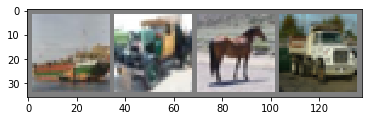

In [58]:
imshow(torchvision.utils.make_grid(images))

In [60]:
untrained_outputs = net.forward(images.to(device))
print(untrained_outputs)

tensor([[ 0.0098, -0.0424, -0.0602,  0.0246, -0.1214,  0.0688,  0.0226,  0.0757,
         -0.0677, -0.0263],
        [ 0.0119, -0.0449, -0.0622,  0.0198, -0.1169,  0.0669,  0.0187,  0.0761,
         -0.0572, -0.0275],
        [ 0.0057, -0.0404, -0.0666,  0.0184, -0.1214,  0.0660,  0.0261,  0.0793,
         -0.0607, -0.0270],
        [ 0.0091, -0.0367, -0.0646,  0.0167, -0.1185,  0.0604,  0.0190,  0.0724,
         -0.0554, -0.0244]], device='cuda:0', grad_fn=<AddmmBackward>)


Remember, we have **4 input images** in the batch, and each output is of size **10**. We'll treat the output as a one-hot vector, selecting the index of each output with the highest value.

In [61]:
untrained_output_ids = torch.argmax(untrained_outputs, axis=-1)
print(untrained_output_ids)
print([classes[j] for j in untrained_output_ids])

tensor([7, 7, 7, 7], device='cuda:0')
['horse', 'horse', 'horse', 'horse']


To train the network, we'll need to define a loss function. We'll use a Classification Cross-Entropy loss.

In [62]:
criterion = nn.CrossEntropyLoss()

We'll also define an **optimizer**. This will handle updating the weights of our network `net` based on the gradients of each back-prop step:

In [63]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Before training the network, let's evaluate the untrained network on the test dataset.

In [64]:
def print_test_accuracy():
    correct = 0
    total = 0
    with torch.no_grad():                 # don't compute gradients for test
        for data in testloader:
            # get data for this batch
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net.forward(images) # run network 
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the %d test images: %d %%' %(
        total, 100 * correct / total))

print_test_accuracy()

Accuracy of the network on the 10000 test images: 9 %


Unsurprisingly, the accuracy is about 10% (random chance).

Now we'll train the network for a couple epochs and see what happens.

In [66]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients every iteration
        optimizer.zero_grad()
        
        # do a forward pass
        outputs = net.forward(inputs)
        
        # compute loss
        loss = criterion(outputs, labels)
        
        # backprop to compute gradients
        loss.backward()
        
        # do a step of gradient descent
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:     # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print("Finished training")

[1,  2000] loss: 2.241
[1,  4000] loss: 1.880
[1,  6000] loss: 1.703
[1,  8000] loss: 1.590
[1, 10000] loss: 1.531
[1, 12000] loss: 1.458
[2,  2000] loss: 1.435
[2,  4000] loss: 1.355
[2,  6000] loss: 1.346
[2,  8000] loss: 1.331
[2, 10000] loss: 1.284
[2, 12000] loss: 1.266
Finished training


We can save the trained model weights to a file, to be loaded later:

In [67]:
torch.save(net.state_dict(), './cifar_net.pth')

Let's inspect some of the data and see how good its predictions are now:

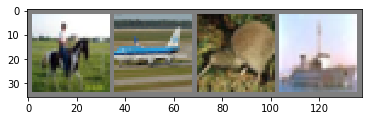

In [69]:
imshow(torchvision.utils.make_grid(images.cpu()))

In [70]:
trained_outputs = net.forward(images)
trained_output_ids = torch.argmax(trained_outputs, axis=-1)
print(trained_output_ids)
print([classes[j] for j in trained_output_ids])

tensor([7, 0, 6, 8], device='cuda:0')
['horse', 'plane', 'frog', 'ship']


And let's run the results on the whole test dataset:

In [71]:
print_test_accuracy()

Accuracy of the network on the 10000 test images: 56 %


The accuracy is now about 50-60%, which is better than the 10% random-chance it was on the untrained network